This is Jupyter Notebook to does the following:
* Open and read training.fa text file consisting of multiple sequences. Each sequence begins with a ">" character followed by the sequence_ID in a single line. All the following lines form the sequence string until the next ">" character.
* Open and read training_class.csv file consisting of sequence_ID and the classification of the sequence. A value of 0 means the seuence identified by the sequence_ID is not mRNA while a value of 1 means the sequence identified by the sequence_ID is mRNA sequence.
* Open and read test.csv consisting of sequence_ID, sequence string and class value as the testing dataset.
* Merge the dataset of training.fa text file and training_class.csv into a single dataset linked by sequence_ID.
* Compute token (character) embeddings then add/concatenate positional embeddings (either relative encodings or locality-aware approach - sliding window, sparse attention, or RoPE) using PyTorch library.
* Tokenize the IUPAC alphabet to indices using PyTorch library and combine character embeddings with positional encodings
* Add a small character level language encoder (BiLSTM/BiGRU) using the pretrain the encoder (in sub-project "BiLSTM/charlm-bilstm) with a language modeling objective and then use pooled encoder outputs as features for Logistic Regression training.
* Train a logistic regression model as a basseline
* Evaluate performance metrics

# STEP-BY-STEP GUIDE TO RUN THIS JUPYTER NOTEBOOK

## Prerequisites:
1. Python 3.8 or higher installed on your system (follow installation guide from website)
2. Visual Studio Code installed (follow installation guide from Visual Studio website for our operating system)

## Step 1: Install Visual Studio Code Extensions
- Open VS Code
- Go to Extensions (Ctrl+Shift+X or Cmd+Shift+X on Mac)
- Search and install the following extensions:
    * "Python" by Microsoft
    * "Jupyter" by Microsoft
    * "Pylance" by Microsoft (usually installed with Python extension)

## Step 2: Set Up Python Environment
Open a terminal/command prompt and create a virtual environment:

Windows:
        python -m venv venv
        venv\Scripts\activate

macOS/Linux:
        python3 -m venv venv
        source venv/bin/activate

## Step 3: Install Required Python Libraries
With the virtual environment activated, run:

        pip install pandas
        pip install torch torchvision torchaudio
        pip install scikit-learn
        pip install numpy
        pip install matplotlib

Or install all at once:
        pip install pandas torch torchvision torchaudio scikit-learn numpy matplotlib imbalanced-learn

## Step 4: Prepare Dataset Files
Ensure you have the following files in the [Project-Home-directory]/dataset/ directory:
- training.fa
- training_class.csv
- test.csv

Create the dataset folder if it doesn't exist:
        mkdir -p ../dataset

## Step 5: Open and Run the Notebook in VS Code
1. Open VS Code
2. Open the folder containing this .ipynb file
3. Click on the .ipynb file to open it
4. VS Code will prompt you to select a kernel - choose the Python environment you created (venv)
5. Run cells sequentially from top to bottom using Shift+Enter or the "Run Cell" button

## Optional: Verify Installation
Run the next cell to verify all libraries are installed correctly.


In [3]:
import sys
import pandas as pd
import torch
import sklearn
import numpy as np
import matplotlib

print(f"Python version: {sys.version}")

try:
        print(f"✓ pandas {pd.__version__}")
except ImportError:
        print("✗ pandas not installed - run: pip install pandas")

try:
        print(f"✓ torch {torch.__version__}")
except ImportError:
        print("✗ torch not installed - run: pip install torch")

try:
        print(f"✓ scikit-learn {sklearn.__version__}")
except ImportError:
        print("✗ scikit-learn not installed - run: pip install scikit-learn")

try:
        print(f"✓ numpy {np.__version__}")
except ImportError:
        print("✗ numpy not installed - run: pip install numpy")

try:
        print(f"✓ matplotlib {matplotlib.__version__}")
except ImportError:
        print("✗ matplotlib not installed - run: pip install matplotlib")

print("\n" + "="*60)
print("If all libraries show ✓, you're ready to run this notebook!")
print("="*60)

Python version: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:38:53) [Clang 18.1.8 ]
✓ pandas 2.3.2
✓ torch 2.6.0
✓ scikit-learn 1.7.2
✓ numpy 2.3.3
✓ matplotlib 3.10.7

If all libraries show ✓, you're ready to run this notebook!


In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


training_fa_file = '../dataset/training.fa'  # Path to training FASTA file
training_class_file = '../dataset/training_class.csv'  # Path to training class CSV file
test_csv_file = '../dataset/test.csv'  # Path to test CSV file

## **Processing-Step-1:** Define a function read_fasta() to read fasta file provided by the filename parameter then calls the read_fasta() function to read training.fa file into a dictionary variable "sequences" and finally print the dictionary.

In [5]:
def read_fasta(filename):
    """
    Read a FASTA file and return a dictionary of sequences.
    
    Args:
        filename: Path to the FASTA file
        
    Returns:
        Dictionary with sequence_IDs as keys and sequences as values
    """
    sequences = {}
    current_id = None
    current_sequence = []
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith('>'):
                # Save previous sequence if it exists
                if current_id is not None:
                    sequences[current_id] = ''.join(current_sequence)
                
                # Start new sequence
                current_id = line[1:]  # Remove '>' character
                current_sequence = []
            else:
                # Add line to current sequence
                current_sequence.append(line)
        
        # Don't forget to save the last sequence
        if current_id is not None:
            sequences[current_id] = ''.join(current_sequence)
    
    return sequences

# Read training sequences from FASTA file
sequences = read_fasta(training_fa_file)

# Print sequence IDs and their lengths
for seq_id, sequence in sequences.items():
    print(f"ID: {seq_id}")
    print(f"Length: {len(sequence)}")
    print(f"Sequence preview: {sequence[:50]}...")
    print()

ID: ENSDART00000138379
Length: 2567
Sequence preview: TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAATACGA...

ID: ENSDART00000075994
Length: 792
Sequence preview: ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATGGCAA...

ID: ENSDART00000153938
Length: 2122
Sequence preview: AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGCCGAA...

ID: ENSDART00000152541
Length: 3957
Sequence preview: CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATGTGCT...

ID: ENSDART00000139170
Length: 1002
Sequence preview: TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAACTTG...

ID: ENSDART00000155306
Length: 763
Sequence preview: CACACAGCAGCTCTGAACCTTCTCATTTTCAACAACAGAAACTATGGTCT...

ID: ENSDART00000133466
Length: 2175
Sequence preview: BBACCGCTTAAAYCCAGGGGGTGGGGACAAAGTGTAATATTTNCGGGATA...

ID: ENSDART00000155270
Length: 1236
Sequence preview: GCTAAACCCTCACCTATTAGCCACAAGGTTTTTTATTAACCATTCTATTA...

ID: ENSDART00000139035
Length: 853
Sequence preview: CAGTTGTTCAGAGGCAGACATTTANTTTGGACCCTGCTAAGAAGAGGCAA...

ID: ENSDART00000153123

## **Processing-Step-2:** Read the training classification file into a pandas dataframe "training_class" in order to add classification (1 = mRNA, 0 = non-mRNA) to the sequences dictionary later.

In [6]:
# Read the training classification file
training_class = pd.read_csv(training_class_file)

# Display the first few rows and class distribution
print(training_class.head())
print(f"\nShape: {training_class.shape}")
print(f"\nClass distribution:\n{training_class['class'].value_counts()}")

                 name  class
0  ENSDART00000138379      1
1  ENSDART00000075994      1
2  ENSDART00000153938      1
3  ENSDART00000152541      1
4  ENSDART00000139170      1

Shape: (22867, 2)

Class distribution:
class
0    14035
1     8832
Name: count, dtype: int64


## **Processing-Step-3:** Read the test dataset into pandas dataframe "test_df" in order to be used for assessment of performance of the trained model later.

In [7]:
# Read the test dataset
test_df = pd.read_csv(test_csv_file)

# Display information about the test dataset
print(test_df.head())
print(f"\nShape: {test_df.shape}")
print(f"\nColumn names: {test_df.columns.tolist()}")
print(f"\nClass distribution:\n{test_df['class'].value_counts()}")
print(f"\nData types:\n{test_df.dtypes}")

             name                                           sequence  class
0  TCONS_00059596  CUAAUCCCCCCUCCUCCCGCUCCCGCACCAAAGAGUUGCGCCGCCU...      1
1  TCONS_00059678  CUAUUCGGCGCAGUUGCUAUACGUACCCCAGCCUCGUACACAACGC...      1
2  TCONS_00059721  CCGCCGCCCCGCCCCGCCCAUCUUGUCAGAUCCUUCUUCAUAGUUA...      1
3  TCONS_00059758  CUCGUCGAUCCGCCGGGUCUUUCCUACUUCACUGUCCAUUGCCCGG...      1
4  TCONS_00060154  AUGGCGGCUCGCCGUUUCUCCGCCGCCACGCCCUCCUCUCCCCUCC...      1

Shape: (4416, 3)

Column names: ['name', 'sequence', 'class']

Class distribution:
class
1    2208
0    2208
Name: count, dtype: int64

Data types:
name        object
sequence    object
class        int64
dtype: object


## **Processing-Step-4:** Create the merged (training.fa + training_class.csv) pandas dataframe name "train_merged"

In [8]:
# Convert the sequences dict to a DataFrame
sequences_df = pd.DataFrame(list(sequences.items()), columns=['name', 'sequence'])

# Merge with training_class DataFrame on 'name'
train_merged = pd.merge(sequences_df, training_class, on='name', how='inner')

# Show the first few rows and shape
print(train_merged.head())
print(f"\nShape: {train_merged.shape}")
print(f"\nClass distribution:\n{train_merged['class'].value_counts()}")

                 name                                           sequence  \
0  ENSDART00000138379  TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...   
1  ENSDART00000075994  ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...   
2  ENSDART00000153938  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...   
3  ENSDART00000152541  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...   
4  ENSDART00000139170  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...   

   class  
0      1  
1      1  
2      1  
3      1  
4      1  

Shape: (22867, 3)

Class distribution:
class
0    14035
1     8832
Name: count, dtype: int64


## **Observation:** Since the merged pandas dataframe "trained_merged" have the same shape as training_class.csv and the same number of sequences as training.fa, the merge did not lose any data and we are safe to proceed.

## **Processing-Step-5:**
- Creation of class "CharPositionalEmbedding" inherited from torch's baseline neural network models
- Creation of function tokenize_sequence() to convert character to integer
- Create an object name "embedding_model" of "charPositionalEmbedding" class of embedding model

Use of AI: ChatGPT used to generate codes in this cell. Subsequently modification to integrate the codes to the other cells.

In [9]:
# Define IUPAC alphabet for DNA/RNA (including ambiguous codes)
# Reserve indices: 0 = PAD, 1 = UNK
PAD_IDX = 0
UNK_IDX = 1
IUPAC_ALPHABET = sorted(list(set('ACGTURYSWKMBDHVN'))) # Define the IUPAC alphabet. 16 characters including ambiguous codes.
# map real chars starting at index 2
char2idx = {ch: i + 2 for i, ch in enumerate(IUPAC_ALPHABET)}
idx2char = {idx: char for char, idx in char2idx.items()}
# add PAD/UNK into reverse mapping if needed
idx2char[PAD_IDX] = '<pad>'
idx2char[UNK_IDX] = '<unk>'
vocab_size = len(char2idx) + 2  # include PAD and UNK
embedding_dim = 16  # Dimension of character embeddings. Can be adjusted but using 16 for simplicity.
max_seq_len = 4096  # Maximum sequence length. To adjust based on dataset.

def tokenize_sequence(seq, char2idx, unk_idx=UNK_IDX):
    # Map each character to its index, unknowns to UNK_IDX
    return [char2idx.get(char, unk_idx) for char in seq]

# Class created through modification from codes generated by ChatGPT.
class CharPositionalEmbedding(nn.Module): #Embedding layer with character embeddings and positional encodings. Inheriting torch baseline neural network modules.
    def __init__(self, vocab_size, embedding_dim, max_len=4096, pos_encoding='rope'):
        super().__init__()
        assert embedding_dim % 2 == 0, "embedding_dim must be even for RoPE"
        # ensure padding index is ignored in embedding updates
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.embedding_dim = embedding_dim
        self.max_len = max_len
        self.pos_encoding = pos_encoding
        if pos_encoding == 'learned':
            self.position_embedding = nn.Embedding(max_len, embedding_dim)

    def forward(self, x):
        # x: (batch, seq_len)
        tok_emb = self.token_embedding(x)  # (batch, seq_len, dim)
        if self.pos_encoding == 'learned':
            positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
            pos_emb = self.position_embedding(positions)
            out = tok_emb + pos_emb
        elif self.pos_encoding == 'rope':
            out = self.apply_rope(tok_emb)
        else:
            out = tok_emb
        return out

    def apply_rope(self, x):
        seq_len = x.size(1)
        dim = x.size(2)
        theta = 10000 ** (torch.arange(0, dim, 2, device=x.device) / dim)
        pos = torch.arange(seq_len, device=x.device)
        idx_theta = torch.einsum('n,d->nd', pos, 1.0 / theta)
        sin, cos = idx_theta.sin(), idx_theta.cos()
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        x_rope = torch.empty_like(x)
        x_rope[..., ::2] = x1 * cos - x2 * sin
        x_rope[..., 1::2] = x1 * sin + x2 * cos
        return x_rope

# Create an object name "embedding_model" of "charPositionalEmbedding" class of embedding model using RoPE (Rotary Position Embedding) that encodes position by rotating pairs of embedding dimensions with position-dependent sin/cos factors and get embeddings
embedding_model = CharPositionalEmbedding(vocab_size, embedding_dim, max_len=max_seq_len, pos_encoding='rope')
print("Class CharPositionalEmbedding created successfully.")
print("Function tokenize_sequence created successfully.")
print("embedding_model object created successfully.")

Class CharPositionalEmbedding created successfully.
Function tokenize_sequence created successfully.
embedding_model object created successfully.


## **Processing-Step-6:** create a class for character tokenization.

- Creation of class "SequenceDataset" inherited from Dataset class of torch library
- Create tokenized dataset of both "train_merged" and "test_df" into "train_dataset" and "test_dataset".

Use of AI: ChatGPT used to generate codes in this cell. Subsequently modification to integrate the codes to the other cells.

In [10]:
# Create a custom Dataset class for sequence data
# Codes generated by ChatGPT and modified to fit the context.
class SequenceDataset(Dataset):
    def __init__(self, dataframe, char2idx, max_len=None):
        """
        Dataset for sequences with character-level tokenization.
        
        Args:
            dataframe: DataFrame with 'sequence' and 'class' columns
            char2idx: Dictionary mapping characters to indices
            max_len: Maximum sequence length (if None, uses longest sequence in dataset)
        """
        self.sequences = dataframe['sequence'].tolist()
        self.labels = dataframe['class'].values
        self.char2idx = char2idx
        
        # Determine max length if not provided
        if max_len is None:
            self.max_len = max(len(seq) for seq in self.sequences)
        else:
            self.max_len = max_len
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        tokenized = tokenize_sequence(sequence, char2idx)
        if len(tokenized) < self.max_len:
            tokenized = tokenized + [PAD_IDX] * (self.max_len - len(tokenized))
        else:
            tokenized = tokenized[:self.max_len]
        return torch.tensor(tokenized, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Create datasets
train_dataset = SequenceDataset(train_merged, char2idx)
test_dataset = SequenceDataset(test_df, char2idx)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Max sequence length in training: {train_dataset.max_len}")
print(f"Max sequence length in test: {test_dataset.max_len}")

# Get first sample to verify the tokenization
sample_seq, sample_label = train_dataset[0]
print(f"\nFirst sample:")
print(f"Tokenized sequence shape: {sample_seq.shape}")
print(f"First 50 tokens: {sample_seq[:50]}")
print(f"Label: {sample_label}")

Training dataset size: 22867
Test dataset size: 4416
Max sequence length in training: 26831
Max sequence length in test: 18887

First sample:
Tokenized sequence shape: torch.Size([26831])
First 50 tokens: tensor([13,  4,  2,  2,  2, 10,  6,  6,  2,  2,  2,  2, 13,  2,  2, 13,  2, 13,
         6, 13,  4,  2,  6, 17, 13,  6, 13,  6,  2, 13, 13, 13, 13, 13,  2,  4,
        13,  4,  6,  2, 10, 13, 13,  2,  2, 13,  2,  4,  6,  2])
Label: 1


## **Processing-Step-7:** Create 4 functions name compute_metrics(), plot_confusion_matrix(), plot_ROC_Curve() and generate_embeddings() to generate metrics of model's performance, plot a visual confusion matrix, Area Under the Receiver Operating Characteristic curve and generation of embeddings to dataset.

In [11]:
def compute_metrics(y_true, y_pred):
    """
    Compute sensitivity, specificity, and MCC for binary classification.
    
    Args:
        y_true: True labels (0 or 1)
        y_pred: Predicted labels (0 or 1)
        
    Returns:
        Dictionary with sensitivity, specificity, mcc, tp, tn, fp, fn, precision, f1-score, recall
    """
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Sensitivity (Recall, True Positive Rate)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true, y_pred)

    # Calculate Precision and F1-score and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
    recall = sensitivity

    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'mcc': mcc,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'f1_score': f1,
        'recall': recall
    }

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix using matplotlib.
    
    Args:
        y_true: True labels (0 or 1)
        y_pred: Predicted labels (0 or 1)
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Show all ticks and label them
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(['0', '1'])
    ax.set_yticklabels(['0', '1'])

    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > cm.max() / 2 else "black"
            ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.colorbar(im)
    plt.show()

# Function to plot ROC Curve
def plot_ROC_Curve(y_true, y_scores):
    """
    Plot an interpretable ROC Curve with AUC and the threshold that maximizes MCC.

    Args:
        y_true: True labels (0 or 1)
        y_scores: Predicted probabilities for the positive class

    Returns:
        (fig, ax, auc, best_t, best_mcc) - useful for further programmatic use
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # Search thresholds (include 0/1 extremes) and pick best by MCC
    search_thresholds = np.linspace(0.0, 1.0, 101)
    best_mcc = -1.0
    best_t = 0.5
    for t in search_thresholds:
        preds_t = (y_scores >= t).astype(int)
        try:
            mcc_t = matthews_corrcoef(y_true, preds_t)
        except Exception:
            mcc_t = -1.0
        if mcc_t > best_mcc:
            best_mcc = mcc_t
            best_t = t

    # Compute FPR/TPR for best threshold (from confusion matrix)
    cm = confusion_matrix(y_true, (y_scores >= best_t).astype(int), labels=[0, 1])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        fpr_best = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tpr_best = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        # fallback
        fpr_best, tpr_best = 0.0, 0.0

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc_score:.4f})', color='tab:blue')
    ax.fill_between(fpr, tpr, alpha=0.15, color='tab:blue')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC=0.5)')

    # Mark and annotate best threshold point
    ax.scatter([fpr_best], [tpr_best], color='red', zorder=5)
    ax.annotate(f't={best_t:.3f}\nMCC={best_mcc:.3f}\nTPR={tpr_best:.3f}\nFPR={fpr_best:.3f}',
                xy=(fpr_best, tpr_best),
                xytext=(fpr_best + 0.05, tpr_best - 0.12),
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                arrowprops=dict(arrowstyle='->', lw=1),
                fontsize=9)

    # Formatting for interpretability
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity / Recall)')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='lower right', framealpha=0.9)
    plt.tight_layout()
    plt.show()

    return fig, ax, auc_score, best_t, best_mcc

# Function to generate embeddings for sequences
def generate_embeddings(dataset, embedding_model, batch_size=32):
    """
    Generate embeddings for all sequences in a dataset.
    
    Args:
        dataset: SequenceDataset object
        embedding_model: CharPositionalEmbedding model
        batch_size: Batch size for processing
        
    Returns:
        numpy array of embeddings (flattened or pooled)
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_embeddings = []
    embedding_model.eval()
    with torch.no_grad():
        for sequences, _ in dataloader:
            embs = embedding_model(sequences)  # (batch, seq_len, dim)
            mask = (sequences != PAD_IDX).unsqueeze(-1).float()  # (batch, seq_len, 1)
            summed = (embs * mask).sum(dim=1)  # (batch, dim)
            lengths = mask.sum(dim=1).clamp(min=1.0)  # avoid zero division
            pooled = summed / lengths  # (batch, dim)
            all_embeddings.append(pooled.cpu().numpy())
    return np.vstack(all_embeddings)

print("Metrics computation and performance assessment functions defined successfully!")

Metrics computation and performance assessment functions defined successfully!


## **Processing-Step-8:** Generate Embeddings for both training and test data

In [12]:
# Train logistic regression baseline model
print("Generating embeddings for training data...")
train_embeddings = generate_embeddings(train_dataset, embedding_model, batch_size=32)
train_labels = train_merged['class'].values

print("Generating embeddings for test data...")
test_embeddings = generate_embeddings(test_dataset, embedding_model, batch_size=32)
test_labels = test_df['class'].values

print(f"\nTraining embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

Generating embeddings for training data...
Generating embeddings for test data...

Training embeddings shape: (22867, 16)
Test embeddings shape: (4416, 16)


## **Processing-Step-9:** Train a logistic regression model as a baseline and assess its performance.

In [15]:
# Train logistic regression model
print("\nTraining Logistic Regression baseline model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(train_embeddings, train_labels)

# Make predictions using test.csv data
test_preds = lr_model.predict(test_embeddings)
print("Predictions on test data completed.")
test_probs = lr_model.predict_proba(test_embeddings)[:, 1]  # Probabilities for positive class
# Compute metrics
print("\n=== Logistic Regression Performance ===")
test_metrics = compute_metrics(test_labels, test_preds)



Training Logistic Regression baseline model...
Predictions on test data completed.

=== Logistic Regression Performance ===


LOGISTIC REGRESSION BASELINE MODEL EVALUATION

BASELINE PERFORMANCE
Sensitivity (Recall/TPR): 0.8868
Specificity (TNR):        0.7237
MCC:                      0.6188

Confusion Matrix:
  True Positives  (TP):  1958
  True Negatives  (TN):  1598
  False Positives (FP):   610
  False Negatives (FN):   250
  Precision:               0.7625
  F1 Score:                0.8199
  Recall:                  0.8868
  Total Samples:         4416


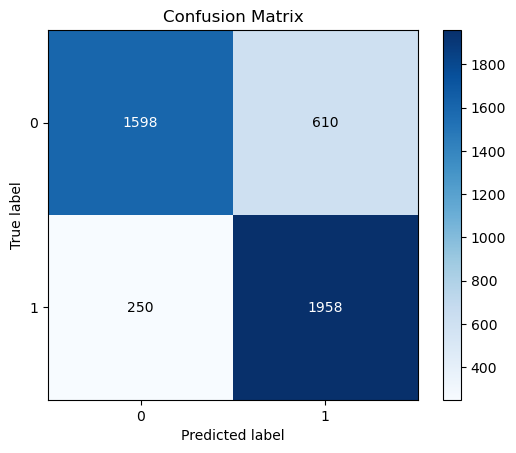

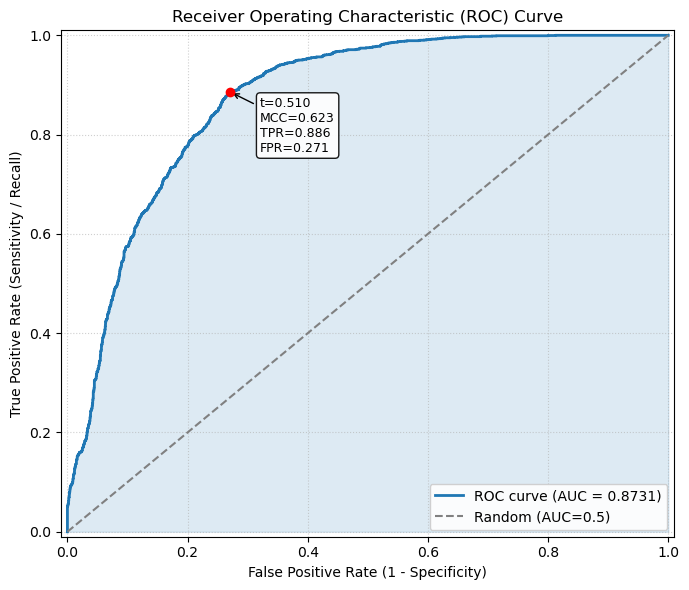

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic (ROC) Curve'}, xlabel='False Positive Rate (1 - Specificity)', ylabel='True Positive Rate (Sensitivity / Recall)'>,
 0.8731084101291745,
 np.float64(0.51),
 0.6227295652571915)

In [16]:
# Print logistic regression model performance metrics
print("=" * 60)
print("LOGISTIC REGRESSION BASELINE MODEL EVALUATION")
print("=" * 60)

print("\n" + "=" * 60)
print("BASELINE PERFORMANCE")
print("=" * 60)
print(f"Sensitivity (Recall/TPR): {test_metrics['sensitivity']:.4f}")
print(f"Specificity (TNR):        {test_metrics['specificity']:.4f}")
print(f"MCC:                      {test_metrics['mcc']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Positives  (TP): {test_metrics['tp']:5d}")
print(f"  True Negatives  (TN): {test_metrics['tn']:5d}")
print(f"  False Positives (FP): {test_metrics['fp']:5d}")
print(f"  False Negatives (FN): {test_metrics['fn']:5d}")
print(f"  Precision:               {test_metrics['precision']:.4f}")
print(f"  F1 Score:                {test_metrics['f1_score']:.4f}")
print(f"  Recall:                  {test_metrics['recall']:.4f}")
print(f"  Total Samples:        {test_metrics['tp'] + test_metrics['tn'] + test_metrics['fp'] + test_metrics['fn']:5d}")

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_preds)
# Plot ROC Curve
test_probs = lr_model.predict_proba(test_embeddings)[:, 1]  # Probabilities for positive class
plot_ROC_Curve(test_labels, test_probs)


# **Analysis and Suggestions based on the baseline model performance assessment**

## Observations:
- Sensitivity of 0.8868 shows average detection of positive class (mRNA sequence predicted correctly)
- Specificity of 0.7237 indicates less than ideal detection of negative class (non-mRNA sequence predicted correctly)
- MCC of 0.6188 indicates above average confidence of predicting correctly.
- Training dataset has class distribution of 14035 Class 0 samples and 8832 Class 1 samples
- The Logistic Regression model trained with RNA sequence consisting of 8032 mRNA (Class 1) and 14035 non-mRNA (Class 0) samples appears to be performing better for new mRNA (Class 1) that had **less samples** during training and less ideal for new non-mRNA sequences that had **more samples** during training
- The behavior of the Logistic Regression model is not normal for a standard model and could indicate a case of class imbalance bias or an issue with data representation.
- The model may have identified a simple, but specific, feature that is highly predictive of the smaller mRNA class, but has failed to learn the more complex patterns that distinguish the broader non-mRNA class - overfitting on a minority signal.
- The issue could also be that the "new" non-mRNA data contains some fundamental differences from the non-mRNA training set, causing the model to fail. However, the consistent failure on all new non-mRNA suggests a more fundamental bias.

## Suggestions:
- Immediate next step: Train a small BiLSTM character language model, extract pooled BiLSTM embeddings for each sequence, train a new Logistic Regression model and evaluate its performance. This will allow the isolation of possible issue (either due to class imbalance or inherent data representation issues)
- Consider resolving class imbalance (using SMOTE) and retrain a new Linear Regression model. This is to confirm if the poor performance for TN is due to class imbalance or due to fundamental bias.
- Consider tuning regularization and penalty (GridSearch with stratified CV - "GridSearchCV") to find the correct hyperparameters that gives the best generalization performance and retrain a new Linear Regression model. This is to confirm if the overfitting is due to having too many correlated features (each position × each nucleotide embedding) resulting in the linear regression model memorizing patterns rather than learning general ones and to find constraint best fits your data through penalty exploration
- Consider improving features/embeddings using other libraries (e.g. BERT) and retrain a new Linear Regression model.
- Once a good baseline Linear Regression model is achieved, proceed to find the best classification model (e.g. Random Forest) through experimentation.




## **Post-Analysis-Tests:** Train a character level language model and retrain a new logistic regresssion model and evaluate the performance.

LM epoch 1/3  avg loss: 0.8666
LM epoch 2/3  avg loss: 0.0726
LM epoch 3/3  avg loss: 0.0356
Extracting BiLSTM embeddings (train/test)...
Train embed shape: (22867, 128), Test embed shape: (4416, 128)
Training Logistic Regression on BiLSTM embeddings...


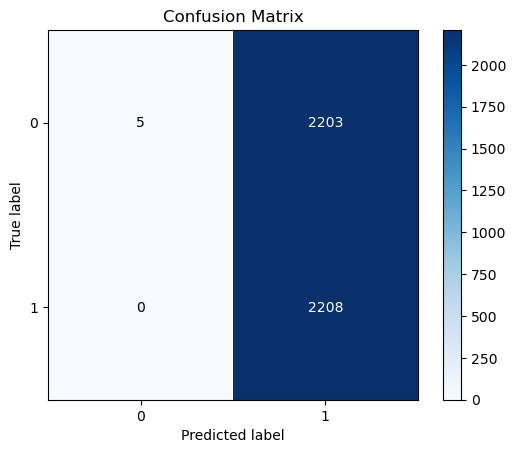

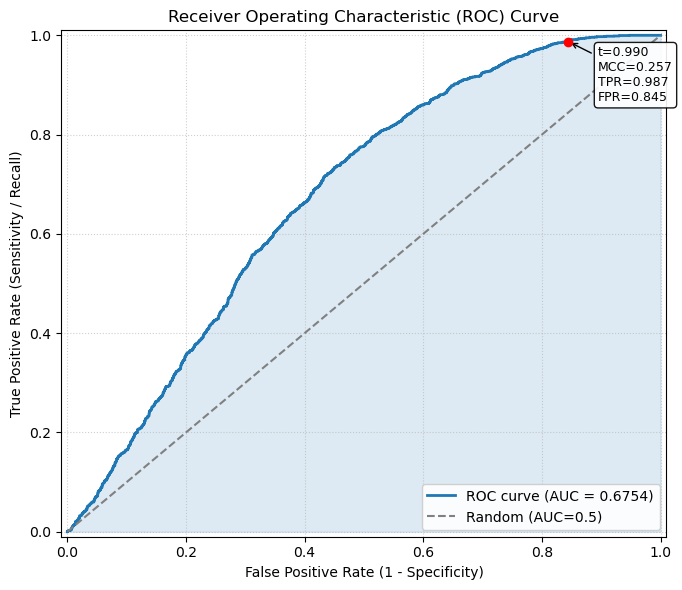


=== Logistic Regression Performance with hyper parameter tuning ===
Sensitivity: 1.0000
Specificity: 0.0023
MCC: 0.0337
TP: 2208, TN: 5, FP: 2203, FN: 0


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LM dataset builder (next-char)
def build_lm_tensor_dataset(df, char2idx, max_len):
    inputs, targets = [], []
    for seq in df['sequence']:
        tok = tokenize_sequence(seq, char2idx)
        tok = tok[:max_len]
        if len(tok) < max_len:
            tok = tok + [PAD_IDX] * (max_len - len(tok))
        inp = tok
        tgt = tok[1:] + [PAD_IDX]
        inputs.append(inp)
        targets.append(tgt)
    return TensorDataset(torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long))

# BiLSTM LM
class BiLSTMCharLM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size=64, num_layers=1, pad_idx=PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers=num_layers, 
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)  # predict next char logits

    def forward(self, x):
        emb = self.embedding(x)                # (B, L, E)
        out, _ = self.lstm(emb)               # (B, L, 2H)
        logits = self.fc(out)                 # (B, L, V)
        return logits, out                    # return logits and LSTM outputs (for embeddings)

# Build LM datasets/loaders
lm_max_len = min(train_dataset.max_len, 1024)  # cap length for LM training if very long
lm_train_ds = build_lm_tensor_dataset(train_merged, char2idx, lm_max_len)
lm_loader = DataLoader(lm_train_ds, batch_size=128, shuffle=True, pin_memory=True)

# Instantiate model, loss, optimizer
lm_hidden = 64
lm_model = BiLSTMCharLM(vocab_size=vocab_size, emb_dim=embedding_dim, hidden_size=lm_hidden).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimiser = optim.Adam(lm_model.parameters(), lr=1e-3)

# Quick training loop (small number of epochs for demonstration)
epochs = 3
lm_model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in lm_loader:
        xb, yb = xb.to(device), yb.to(device)              # xb: (B,L) ; yb: (B,L)
        optimiser.zero_grad()
        logits, _ = lm_model(xb)                           # logits: (B,L,V)
        loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
        loss.backward()
        optimiser.step()
        total_loss += loss.item() * xb.size(0)
    print(f'LM epoch {epoch+1}/{epochs}  avg loss: {total_loss/len(lm_train_ds):.4f}')

# Embedding extraction using BiLSTM outputs (masked mean pooling)
def extract_bilstm_embeddings(df, model, char2idx, max_len, batch_size=128):
    ds = build_lm_tensor_dataset(df, char2idx, max_len)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model.eval()
    embs_list = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            _, lstm_out = model(xb)                 # (B, L, 2H)
            mask = (xb != PAD_IDX).unsqueeze(-1).float()  # (B, L, 1)
            summed = (lstm_out * mask).sum(dim=1)        # (B, 2H)
            lengths = mask.sum(dim=1).clamp(min=1.0)     # (B,1)
            pooled = summed / lengths                    # (B, 2H)
            embs_list.append(pooled.cpu().numpy())
    return np.vstack(embs_list)

# Extract embeddings and plug into logistic regression (replace previous embeddings)
print("Extracting BiLSTM embeddings (train/test)...")
train_bilstm_embeddings = extract_bilstm_embeddings(train_merged, lm_model, char2idx, lm_max_len, batch_size=128)
test_bilstm_embeddings  = extract_bilstm_embeddings(test_df,    lm_model, char2idx, lm_max_len, batch_size=128)

print(f"Train embed shape: {train_bilstm_embeddings.shape}, Test embed shape: {test_bilstm_embeddings.shape}")

# Retrain logistic regression on BiLSTM embeddings
print("Training Logistic Regression on BiLSTM embeddings...")
log_reg_bilstm = LogisticRegression(max_iter=2000, class_weight=None, random_state=42)
log_reg_bilstm.fit(train_bilstm_embeddings, train_labels)

# Evaluate on test set
test_preds_bilstm = log_reg_bilstm.predict(test_bilstm_embeddings)
probs_bilstm = log_reg_bilstm.predict_proba(test_bilstm_embeddings)[:, 1]

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_preds_bilstm)
# Plot ROC Curve
plot_ROC_Curve(test_labels, probs_bilstm)

# Compute metrics
print("\n=== Logistic Regression Performance with hyper parameter tuning ===")
test_metrics = compute_metrics(test_labels, test_preds_bilstm)
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"MCC: {test_metrics['mcc']:.4f}")
print(f"TP: {test_metrics['tp']}, TN: {test_metrics['tn']}, FP: {test_metrics['fp']}, FN: {test_metrics['fn']}")


# **Conclusion:**
##    Logistic Regression model trained using character level embedding extracted by a trained character level language model shows possible overfitting with all Class 1 predicted correctly and all Class 0 predicted wrongly. There is a need to do class balancing and retry Logistic Regression training using character tokenization and positional embedding method. This will then form the baseline model while we explore better classification algorithm (e.g. Random Forest) as the final solution.